In [21]:
import os,cv2
import numpy as np 
from sklearn.model_selection import train_test_split

import numpy as np 
import pandas as pd
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy

import time

In [22]:
# Set the path for the dataset
directory = '/kaggle/input/ckplus/CK+48'

# Get the list of directories in the dataset directory
dir_list = os.listdir(directory)

# Initialize lists to store image data, labels, and emotions
image_data_list = []
labels = []
emotions = []
l = 0

# Iterate over each directory in the dataset
for data_dir in dir_list:
    # Get the list of images in the current directory
    data_list = os.listdir(directory + '/' + data_dir)
    
    # Iterate over each image in the directory
    for img in data_list:
        # Read and resize the image
        input_img = cv2.imread(directory + '/' + data_dir + '/' + img)
        input_img = cv2.resize(input_img, (48, 48))
        
        # Append the image data and label to the respective lists
        image_data_list.append(input_img)
        labels.append(l)
    
    # Append the emotion label to the emotions list
    emotions.append(data_dir)
    l = l + 1
 

# Normalize the image data
img_data = np.array(image_data_list)
img_data = img_data / 255

# Print the shape of the image data
print(img_data.shape)


(981, 48, 48, 3)


In [23]:
# Perform a stratified train-test split
train_images, test_images, train_labels, test_labels = train_test_split(
    img_data, labels, test_size=0.1, stratify=labels, random_state=42
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Print the shape of the train and test datasets
print("Train dataset shape:", train_dataset.reduce(0, lambda x, _: x + 1).numpy())
print("Test dataset shape:", test_dataset.reduce(0, lambda x, _: x + 1).numpy())

Train dataset shape: 882
Test dataset shape: 99


In [24]:
# import matplotlib.pyplot as plt

# # Count the occurrences of each class in the train set
# train_class_counts = np.bincount(train_labels)

# # Count the occurrences of each class in the test set
# test_class_counts = np.bincount(test_labels)

# # Get the class labels
# class_labels = [f"{emotions[i]} ({i})" for i in range(len(emotions))]

# # Print the number of images per class in the train set
# print("Train Set:")
# for i, count in enumerate(train_class_counts):
#     print(f"{class_labels[i]}: {count} images")

# # Print the number of images per class in the test set
# print("\nTest Set:")
# for i, count in enumerate(test_class_counts):
#     print(f"{class_labels[i]}: {count} images")

# # Set the x-axis labels
# x_ticks = np.arange(len(emotions))

# # Plot the class distribution in the train and test sets on the same graph
# plt.figure(figsize=(10, 5))
# plt.bar(x_ticks - 0.2, train_class_counts, width=0.4, align='center', color='blue', label='Train')
# plt.bar(x_ticks + 0.2, test_class_counts, width=0.4, align='center', color='green', label='Test')
# plt.xticks(x_ticks, class_labels, rotation='vertical')
# plt.xlabel('Clasa')
# plt.ylabel('Numarul de imagini')
# plt.title('Distributia seturilor de train si test pe clase')
# plt.legend()
# plt.tight_layout()
# plt.show()


In [25]:
from keras.applications import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

In [26]:
# Freeze the pre-trained layers
for layer in vgg_model.layers:
    layer.trainable = False

In [27]:
num_classes = 7

In [28]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x) # Dropout layer to reduce overfitting
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x) # Softmax for multiclass classification
transfer_model = keras.Model(inputs=vgg_model.input, outputs=x)

In [29]:
# transfer_model.layers[-1].units = num_classes

# Compile the model again after modifying the output shape
transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [30]:
import numpy as np


# Convert train_labels to a NumPy array
train_labels = np.array(train_labels)

# Verify the shapes of train_images and train_labels
print(train_images.shape)
print(train_labels.shape)

# Ensure that train_images and train_labels are in the correct format and shape

# Start the timer
start_time = time.time()

# Continue with model fitting
history = transfer_model.fit(train_images, train_labels, epochs=40, batch_size=32)

# Calculate the total execution time
end_time = time.time()
execution_time = end_time - start_time
print("Total execution time: {:.2f} seconds".format(execution_time))


(882, 48, 48, 3)
(882,)
Epoch 1/40
28/28 [==============================] - 12s 380ms/step - loss: 1.6516 - accuracy: 0.4059
Epoch 2/40
28/28 [==============================] - 11s 378ms/step - loss: 1.1878 - accuracy: 0.6156
Epoch 3/40
28/28 [==============================] - 11s 393ms/step - loss: 0.9331 - accuracy: 0.6689
Epoch 4/40
28/28 [==============================] - 11s 375ms/step - loss: 0.7665 - accuracy: 0.7279
Epoch 5/40
28/28 [==============================] - 11s 380ms/step - loss: 0.6758 - accuracy: 0.7710
Epoch 6/40
28/28 [==============================] - 11s 394ms/step - loss: 0.5695 - accuracy: 0.8005
Epoch 7/40
28/28 [==============================] - 11s 379ms/step - loss: 0.5022 - accuracy: 0.8424
Epoch 8/40
28/28 [==============================] - 11s 378ms/step - loss: 0.4520 - accuracy: 0.8651
Epoch 9/40
28/28 [==============================] - 11s 395ms/step - loss: 0.4083 - accuracy: 0.8730
Epoch 10/40
28/28 [==============================] - 11s 378ms/step

In [31]:
predicted_labels = transfer_model.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=-1)

accuracy = np.sum(predicted_classes == test_labels) / len(test_labels)
print("Accuracy on test set: {:.2f}%".format(accuracy * 100))



4/4 [==============================] - 1s 267ms/step
Accuracy on test set: 98.99%


4/4 [==============================] - 1s 273ms/step


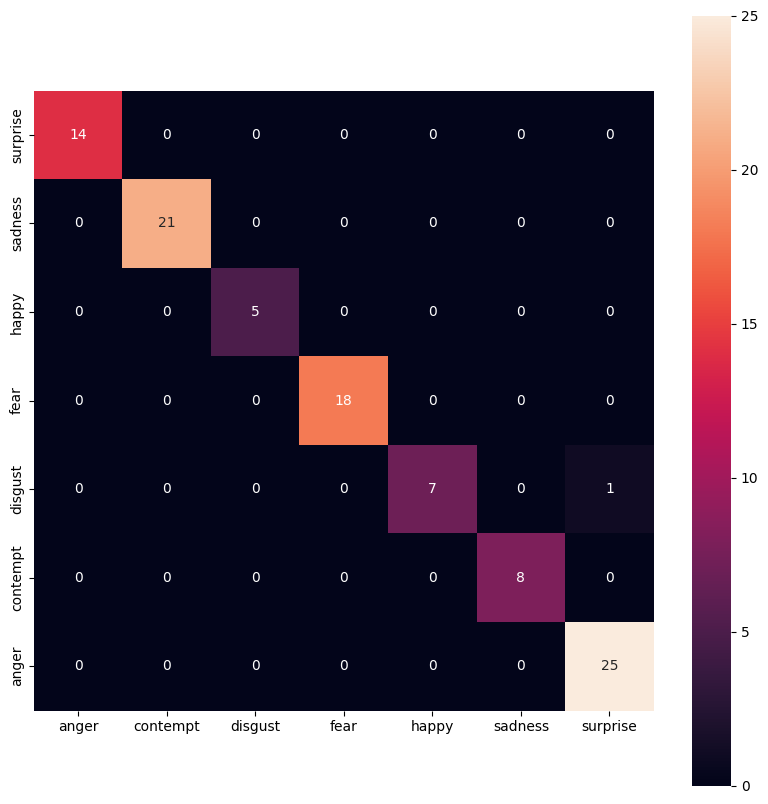

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

emotion_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

y_pred = transfer_model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
classes = np.unique(test_labels)  # Get unique classes from test_labels

# Calculate confusion matrix
cm = confusion_matrix(test_labels, y_pred)

fig = plt.figure(figsize=(10, 10))
cf = pd.DataFrame(cm[::-1, ::-1], columns=emotion_labels, index=emotion_labels[::-1])  # Reverse order of emotion_labels
sns.heatmap(cf, annot=True, square=True)

plt.show()


